In [24]:
import pandas as pd
import numpy as np
import glob
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support





Data is present in Epl/data/ and seperate features required are taken to reduce the difficulties in cleaning..empty coloumns if any are filled with NaN.

In [25]:
# Load only Premier League CSVs (E0)
files = glob.glob("C:/Epl/data/E0*.csv")
print(files)
features=["Date","HomeTeam","AwayTeam","HTHG","HTAG","HS","AS","HST","AST","HF","AF","HC","AC","HY","AY","HR","AR"]
target ="FTR"
dfs = []
for f in files:
    df = pd.read_csv(f, encoding='cp1252', on_bad_lines='skip')
    for col in features:
        if col not in df.columns:
         df[col] = pd.NA
    df = df[features + [target]]
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)
data["Date"] = pd.to_datetime(data["Date"], dayfirst=True, errors="coerce")
print("Shape:", data.shape)
print(data.head())


['C:/Epl/data\\E02000.csv', 'C:/Epl/data\\E02001.csv', 'C:/Epl/data\\E02002.csv', 'C:/Epl/data\\E02003.csv', 'C:/Epl/data\\E02004.csv', 'C:/Epl/data\\E02005.csv', 'C:/Epl/data\\E02006.csv', 'C:/Epl/data\\E02007.csv', 'C:/Epl/data\\E02008.csv', 'C:/Epl/data\\E02009.csv', 'C:/Epl/data\\E02010.csv', 'C:/Epl/data\\E02011.csv', 'C:/Epl/data\\E02012.csv', 'C:/Epl/data\\E02013.csv', 'C:/Epl/data\\E02014.csv', 'C:/Epl/data\\E02015.csv', 'C:/Epl/data\\E02016.csv', 'C:/Epl/data\\E02017.csv', 'C:/Epl/data\\E02018.csv', 'C:/Epl/data\\E02019.csv', 'C:/Epl/data\\E02020.csv', 'C:/Epl/data\\E02021.csv', 'C:/Epl/data\\E02022.csv', 'C:/Epl/data\\E02023.csv', 'C:/Epl/data\\E02024.csv']
Shape: (9411, 18)
        Date  HomeTeam       AwayTeam  HTHG  HTAG    HS    AS   HST  AST  \
0 2000-08-19  Charlton       Man City   2.0   0.0  17.0   8.0  14.0  4.0   
1 2000-08-19   Chelsea       West Ham   1.0   0.0  17.0  12.0  10.0  5.0   
2 2000-08-19  Coventry  Middlesbrough   1.0   1.0   6.0  16.0   3.0  9.0   
3 

C:\Users\arnas\AppData\Local\Temp\ipykernel_20292\2351140533.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Date"] = pd.to_datetime(data["Date"], dayfirst=True, errors="coerce")


Now that data is ready we have to clean it by checking for duplicates and null values.

In [26]:
print(data.isnull().sum())
print((data.isnull().mean()*100).round(2))

Date        1
HomeTeam    1
AwayTeam    1
HTHG        1
HTAG        1
HS          1
AS          1
HST         1
AST         1
HF          1
AF          1
HC          1
AC          1
HY          1
AY          1
HR          1
AR          1
FTR         1
dtype: int64
Date        0.01
HomeTeam    0.01
AwayTeam    0.01
HTHG        0.01
HTAG        0.01
HS          0.01
AS          0.01
HST         0.01
AST         0.01
HF          0.01
AF          0.01
HC          0.01
AC          0.01
HY          0.01
AY          0.01
HR          0.01
AR          0.01
FTR         0.01
dtype: float64


This shows that the dataset has only a very few negligable output there is 1 missing value and that missing value exists in all features so we could drop that row.

In [27]:
data = data.dropna()
print("After dropping missing:",data.shape)
print("Remaining NaN:",data.isnull().sum().sum())

After dropping missing: (9410, 18)
Remaining NaN: 0


In [28]:
duplicates = data.duplicated().sum()
print("Number of duplicated rows:",duplicates)

Number of duplicated rows: 0


In [29]:
print(data.columns)
le = LabelEncoder()
data['FTR']=le.fit_transform(data['FTR'])
data['Date'] = data['Date'].astype(str)

Index(['Date', 'HomeTeam', 'AwayTeam', 'HTHG', 'HTAG', 'HS', 'AS', 'HST',
       'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'FTR'],
      dtype='object')


I have done label encoding for all categorical coloumns and the encoder function is also saved in encoders[] to decode for further use

In [30]:
import pandas as pd
import numpy as np

data['HT_goal_diff'] = data['HTHG'] - data['HTAG']


data['corner_diff'] = data['HC'] - data['AC']


data['home_shot_accuracy'] = data['HST'] / data['HS'].replace(0, 1)
data['away_shot_accuracy'] = data['AST'] / data['AS'].replace(0, 1)


data['cards_diff'] = ((data['HY'] + 2*data['HR']) -
                    (data['AY'] + 2*data['AR']))


data['fouls_diff'] = data['HF'] - data['AF']


data['shots_diff'] = data['HS'] - data['AS']

data['shots_on_target_diff'] = data['HST'] - data['AST']


In [31]:
#splitting data into label and feature input

y = data['FTR']

X = data.drop('FTR', axis=1)


In [32]:
print(data.head())

         Date  HomeTeam       AwayTeam  HTHG  HTAG    HS    AS   HST  AST  \
0  2000-08-19  Charlton       Man City   2.0   0.0  17.0   8.0  14.0  4.0   
1  2000-08-19   Chelsea       West Ham   1.0   0.0  17.0  12.0  10.0  5.0   
2  2000-08-19  Coventry  Middlesbrough   1.0   1.0   6.0  16.0   3.0  9.0   
3  2000-08-19     Derby    Southampton   1.0   2.0   6.0  13.0   4.0  6.0   
4  2000-08-19     Leeds        Everton   2.0   0.0  17.0  12.0   8.0  6.0   

     HF  ...   AR  FTR  HT_goal_diff  corner_diff  home_shot_accuracy  \
0  13.0  ...  0.0    2           2.0          0.0            0.823529   
1  19.0  ...  0.0    2           1.0          0.0            0.588235   
2  15.0  ...  0.0    0           0.0          4.0            0.500000   
3  11.0  ...  0.0    1          -1.0         -3.0            0.666667   
4  21.0  ...  0.0    2           2.0          2.0            0.470588   

   away_shot_accuracy  cards_diff  fouls_diff  shots_diff  \
0            0.500000        -1.0    

Splitting Data

In [45]:
from sklearn.model_selection import train_test_split
# Stratified split to preserve class ratios
X_train_cat_split, X_test_cat_split, y_train_cat_split, y_test_cat_split = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


CATBOOST CLASSIFIER

Fitting with catboost 

In [46]:
# Define which columns are categorical
from catboost import CatBoostClassifier
cat_features = ['HomeTeam', 'AwayTeam', 'Date']

# Build model
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=7,
    loss_function='MultiClass',
    auto_class_weights='Balanced',
    early_stopping_rounds=50,
    verbose=100
)

# Train model
model.fit(X_train_cat_split, y_train_cat_split, cat_features=cat_features, eval_set=(X_test_cat_split, y_test_cat_split))


0:	learn: 1.0747858	test: 1.0755246	best: 1.0755246 (0)	total: 41.9ms	remaining: 41.8s
100:	learn: 0.7536707	test: 0.8081766	best: 0.8081442 (99)	total: 4.81s	remaining: 42.8s
200:	learn: 0.7035799	test: 0.8013977	best: 0.8011503 (163)	total: 9.44s	remaining: 37.5s
300:	learn: 0.6561751	test: 0.8014106	best: 0.8001670 (277)	total: 13.9s	remaining: 32.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8001669608
bestIteration = 277

Shrink model to first 278 iterations.


Predicting and accuracy

In [47]:
y_pred = model.predict(X_test_cat_split)

# Accuracy
print("Accuracy:", accuracy_score(y_test_cat_split, y_pred))

# Full classification report
print(classification_report(y_test_cat_split, y_pred))


Accuracy: 0.6301806588735388
              precision    recall  f1-score   support

           0       0.68      0.69      0.69       556
           1       0.37      0.46      0.41       464
           2       0.79      0.68      0.73       862

    accuracy                           0.63      1882
   macro avg       0.61      0.61      0.61      1882
weighted avg       0.65      0.63      0.64      1882



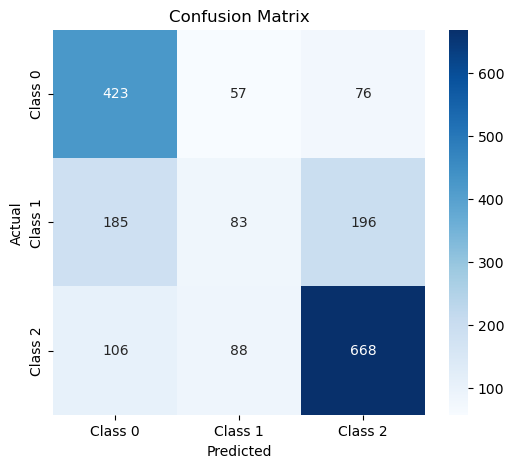

In [58]:
cm = confusion_matrix(y_test_cat_split, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0','Class 1','Class 2'], 
            yticklabels=['Class 0','Class 1','Class 2'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


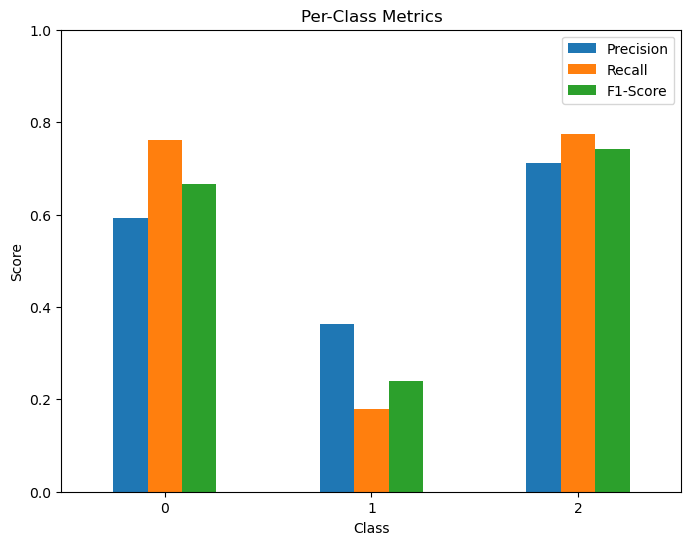

In [59]:
prec, rec, f1, _ = precision_recall_fscore_support(y_test_cat_split, y_pred, average=None)

metrics_df = {
    "Class": ['0','1','2'],
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1
}

metrics_df = pd.DataFrame(metrics_df)

metrics_df.plot(x="Class", kind="bar", figsize=(8,6))
plt.title("Per-Class Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.show()

In [37]:
data = data.drop(columns=["Date"])
categorical_col = data.select_dtypes(include ='object').columns
encoders = {}
for c in categorical_col:
    le = LabelEncoder()
    data[c]=le.fit_transform(data[c])
    encoders[c]=le
print(data.head())

   HomeTeam  AwayTeam  HTHG  HTAG    HS    AS   HST  AST    HF    AF  ...  \
0        12        26   2.0   0.0  17.0   8.0  14.0  4.0  13.0  12.0  ...   
1        13        43   1.0   0.0  17.0  12.0  10.0  5.0  19.0  14.0  ...   
2        14        28   1.0   1.0   6.0  16.0   3.0  9.0  15.0  21.0  ...   
3        16        36   1.0   2.0   6.0  13.0   4.0  6.0  11.0  13.0  ...   
4        22        17   2.0   0.0  17.0  12.0   8.0  6.0  21.0  20.0  ...   

    AR  FTR  HT_goal_diff  corner_diff  home_shot_accuracy  \
0  0.0    2           2.0          0.0            0.823529   
1  0.0    2           1.0          0.0            0.588235   
2  0.0    0           0.0          4.0            0.500000   
3  0.0    1          -1.0         -3.0            0.666667   
4  0.0    2           2.0          2.0            0.470588   

   away_shot_accuracy  cards_diff  fouls_diff  shots_diff  \
0            0.500000        -1.0         1.0         9.0   
1            0.416667        -1.0         

Splitting data for xgboost

In [49]:
y = data['FTR']
x = data.drop('FTR',axis=1)

In [50]:
from sklearn.model_selection import train_test_split
# Stratified split to preserve class ratios
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter



from collections import Counter

# Count samples in training set
counts = Counter(y_train_split)
total = sum(counts.values())

class_weight = {cls: total / (len(counts) * count) for cls, count in counts.items()}
print(class_weight)



counts = Counter(y_train_split)
print("Before SMOTE:", counts)
undetermined_label = 1  
multiplier = 2
target_samples = counts[undetermined_label] * multiplier
sm = SMOTE(sampling_strategy={undetermined_label: target_samples}, random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_split, y_train_split)

print("After SMOTE:", Counter(y_train_res))
X_train_res = X_train_res.astype(np.float32)
y_train_res = y_train_res.astype(np.int64)
print(X_train_res.shape)
print(y_train_res.shape)




print("Class distribution after SMOTE:", dict(zip(*np.unique(y_train_res, return_counts=True))))

{1: 1.353469974829198, 2: 0.7277648878576953, 0: 1.1272836178496557}
Before SMOTE: Counter({2: 3448, 0: 2226, 1: 1854})
After SMOTE: Counter({1: 3708, 2: 3448, 0: 2226})
(9382, 24)
(9382,)
Class distribution after SMOTE: {np.int64(0): np.int64(2226), np.int64(1): np.int64(3708), np.int64(2): np.int64(3448)}


In [ ]:

weights = compute_sample_weight(class_weight='balanced', y=y_train_res)
model = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    objective='multi:softprob',  
    num_class=3,
    eval_metric='mlogloss',
    random_state = 42
)
param_grid = {
    'n_estimators':[800,1000],
    'max_depth': [4, 5, 6],
    'learning_rate':[0.05,0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1_macro',  
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_res, y_train_res,sample_weight=weights)
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 800, 'subsample': 0.7}


In [ ]:

from sklearn.metrics import f1_score

# Get predicted probabilities
y_proba = best_model.predict_proba(X_test_split)

# Custom thresholds per class
thresholds = [0.4, 0.6, 0.4]  # start with 0.5 for all classes

def predict_with_thresholds(probs, thresholds):
    preds = []
    for p in probs:
     #Assign class if probability > threshold, else take max
        assigned = [i for i, prob in enumerate(p) if prob >= thresholds[i]]
        if assigned:
            preds.append(assigned[0])
        else:
            preds.append(np.argmax(p))
    return np.array(preds)

y_pred = predict_with_thresholds(y_proba, thresholds)

print("F1 score macro:", f1_score(y_test_split, y_pred, average='macro'))



F1 score macro: 0.5451007271927099


In [ ]:

# Accuracy
print("Accuracy:", accuracy_score(y_test_split, y_pred))

# Full classification report
print(classification_report(y_test_split, y_pred))


Accuracy: 0.6238044633368757
              precision    recall  f1-score   support

           0       0.66      0.68      0.67       556
           1       0.38      0.47      0.42       464
           2       0.79      0.67      0.72       862

    accuracy                           0.62      1882
   macro avg       0.61      0.61      0.60      1882
weighted avg       0.65      0.62      0.63      1882



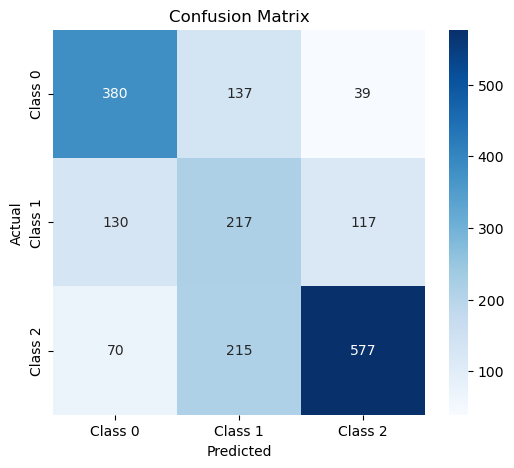

In [105]:
cm = confusion_matrix(y_test_split, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0','Class 1','Class 2'], 
            yticklabels=['Class 0','Class 1','Class 2'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


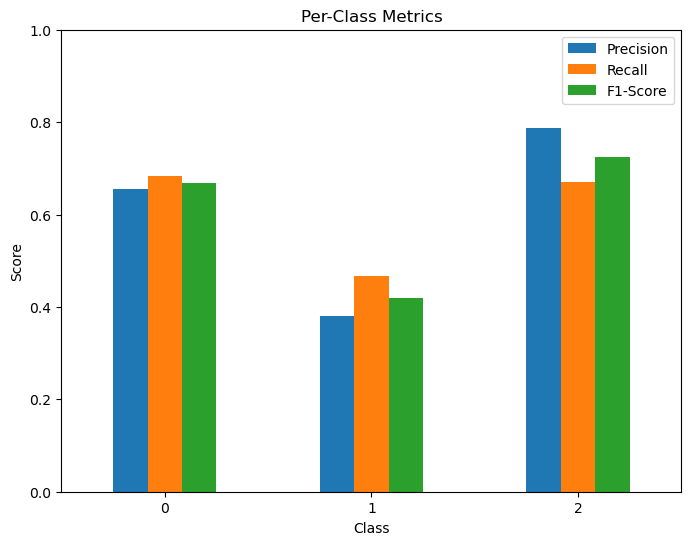

In [106]:
prec, rec, f1, _ = precision_recall_fscore_support(y_test_split, y_pred, average=None)

metrics_df = {
    "Class": ['0','1','2'],
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1
}

metrics_df = pd.DataFrame(metrics_df)

metrics_df.plot(x="Class", kind="bar", figsize=(8,6))
plt.title("Per-Class Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.show()

BALANCED RANDOM FOREST CLASSIFIER

In [99]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Define parameter grid
param_dist = {
    "n_estimators": [800,1000,1200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4,5,10],
    "max_features": ['sqrt','log2']
}

# Initialize model
rf = BalancedRandomForestClassifier(random_state=42)

# Randomized search
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=20,  
    cv=3,       
    scoring="f1_macro",  
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_split, y_train_split)

print("Best Parameters:", random_search.best_params_)
print("Best Score (CV F1):", random_search.best_score_)


Best Parameters: {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 10}
Best Score (CV F1): 0.6081930932816711


In [100]:
best_rf = random_search.best_estimator_

y_proba = best_rf.predict_proba(X_test_split)
y_pred = np.argmax(y_proba, axis=1) 


In [101]:
# Accuracy
print("Accuracy:", accuracy_score(y_test_split, y_pred))

# Full classification report
print(classification_report(y_test_split, y_pred))

Accuracy: 0.6238044633368757
              precision    recall  f1-score   support

           0       0.66      0.68      0.67       556
           1       0.38      0.47      0.42       464
           2       0.79      0.67      0.72       862

    accuracy                           0.62      1882
   macro avg       0.61      0.61      0.60      1882
weighted avg       0.65      0.62      0.63      1882



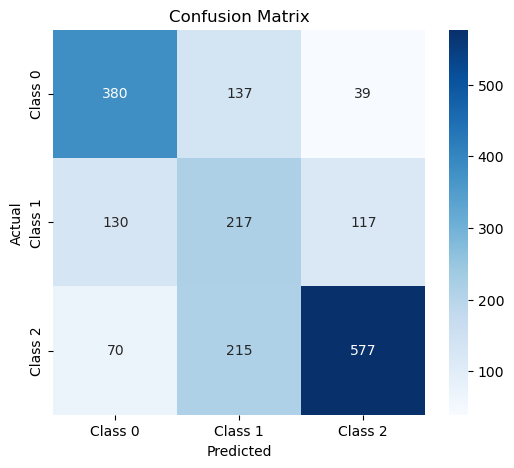

In [102]:
cm = confusion_matrix(y_test_split, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0','Class 1','Class 2'], 
            yticklabels=['Class 0','Class 1','Class 2'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


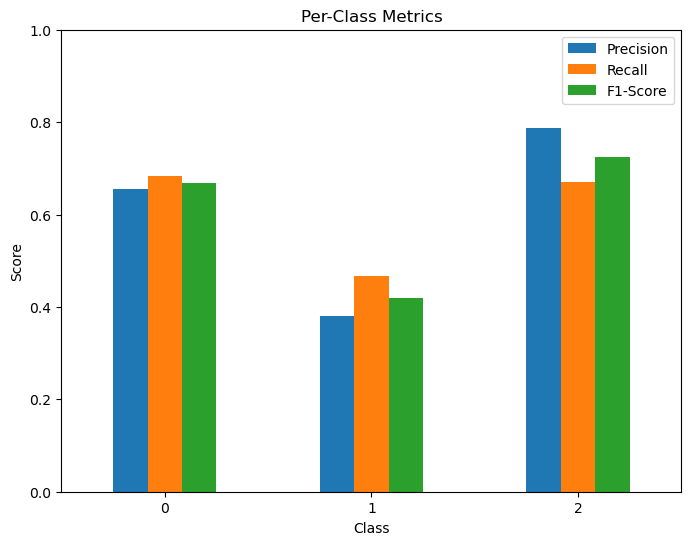

In [103]:
prec, rec, f1, _ = precision_recall_fscore_support(y_test_split, y_pred, average=None)

metrics_df = {
    "Class": ['0','1','2'],
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1
}

metrics_df = pd.DataFrame(metrics_df)

metrics_df.plot(x="Class", kind="bar", figsize=(8,6))
plt.title("Per-Class Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.show()

RANDOM FOREST CLASSIFIER

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Define parameter grid
param_dist = {
    "n_estimators": [800,1000,1200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4,5,10],
    "max_features": ['sqrt','log2'],
    "bootstrap": [True, False]
}

# Initialize model
rf = RandomForestClassifier(random_state=42)

# Randomized search
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=20,  # number of random combinations
    cv=3,       # 3-fold cross validation
    scoring="f1_macro",  # you can also try "accuracy"
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_res, y_train_res)

print("Best Parameters:", random_search.best_params_)
print("Best Score (CV F1):", random_search.best_score_)

Best Parameters: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
Best Score (CV F1): 0.6865774115877455


In [89]:
best_rf = random_search.best_estimator_

y_proba = best_rf.predict_proba(X_test_split)
y_pred = np.argmax(y_proba, axis=1) 


In [90]:
# Accuracy
print("Accuracy:", accuracy_score(y_test_split, y_pred))

# Full classification report
print(classification_report(y_test_split, y_pred))

Accuracy: 0.6238044633368757
              precision    recall  f1-score   support

           0       0.66      0.68      0.67       556
           1       0.38      0.47      0.42       464
           2       0.79      0.67      0.72       862

    accuracy                           0.62      1882
   macro avg       0.61      0.61      0.60      1882
weighted avg       0.65      0.62      0.63      1882



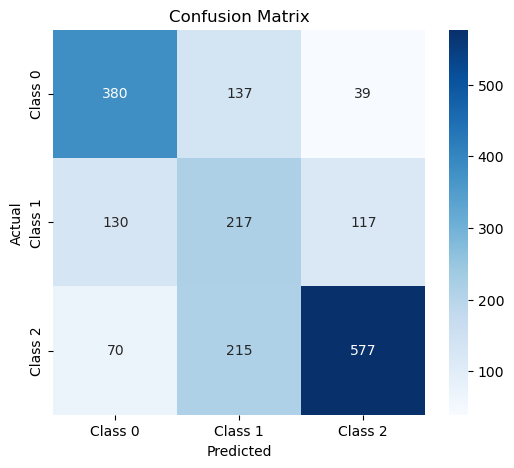

In [91]:
cm = confusion_matrix(y_test_split, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0','Class 1','Class 2'], 
            yticklabels=['Class 0','Class 1','Class 2'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


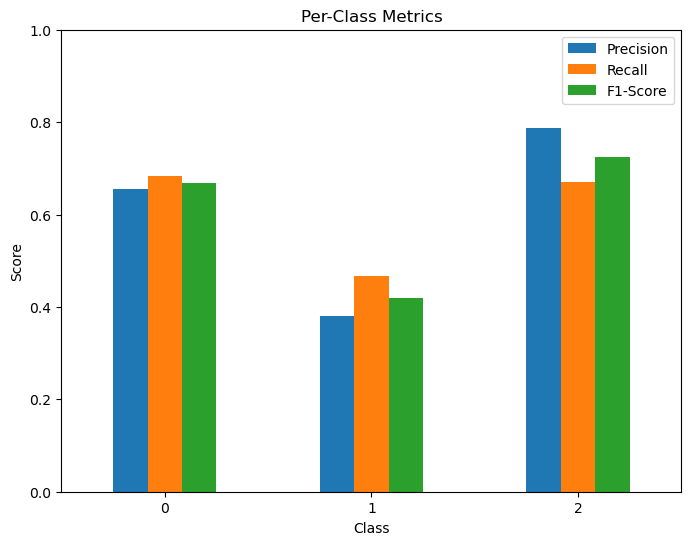

In [93]:
prec, rec, f1, _ = precision_recall_fscore_support(y_test_split, y_pred, average=None)

metrics_df = {
    "Class": ['0','1','2'],
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1
}

metrics_df = pd.DataFrame(metrics_df)

metrics_df.plot(x="Class", kind="bar", figsize=(8,6))
plt.title("Per-Class Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.show()

In [113]:
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
import numpy as np

# Base classifier options
base_estimators = [
    DecisionTreeClassifier(max_depth=1),
    DecisionTreeClassifier(max_depth=2),
    DecisionTreeClassifier(max_depth=3)
]

# Parameter grid
param_dist = {
    "n_estimators": [10, 20, 30],
    "estimator": base_estimators
}

# Initialize EasyEnsemble
eec = EasyEnsembleClassifier(random_state=42, n_jobs=-1)

# Randomized search
rs = RandomizedSearchCV(
    estimator=eec,
    param_distributions=param_dist,
    n_iter=10,        # number of random combinations
    cv=3,             # 3-fold cross-validation
    scoring="f1_macro",  # optimize macro F1 (balances all classes)
    n_jobs=-1,
    random_state=42
)

# Fit on original imbalanced data (EEC handles balancing internally)
rs.fit(X_train_split, y_train_split)

# Best parameters
print("Best Parameters:", rs.best_params_)
print("Best CV F1 (macro):", rs.best_score_)

# Evaluate on test set
y_pred = rs.predict(X_test_split)
print(classification_report(y_test_split, y_pred))


c:\Users\arnas\miniconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'n_estimators': 10, 'estimator': DecisionTreeClassifier(max_depth=2)}
Best CV F1 (macro): 0.5960295255351604
              precision    recall  f1-score   support

           0       0.69      0.60      0.64       556
           1       0.35      0.56      0.43       464
           2       0.79      0.60      0.68       862

    accuracy                           0.59      1882
   macro avg       0.61      0.58      0.58      1882
weighted avg       0.65      0.59      0.61      1882



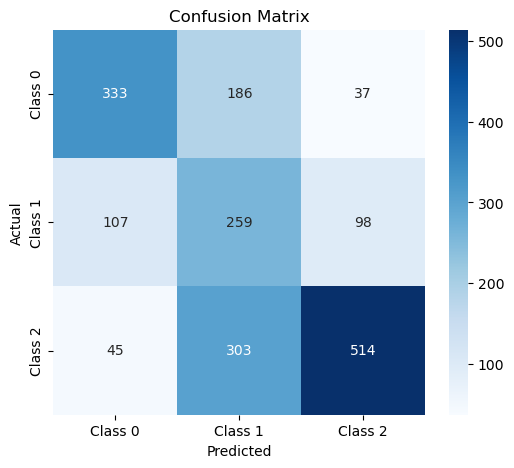

In [114]:
cm = confusion_matrix(y_test_split, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0','Class 1','Class 2'], 
            yticklabels=['Class 0','Class 1','Class 2'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


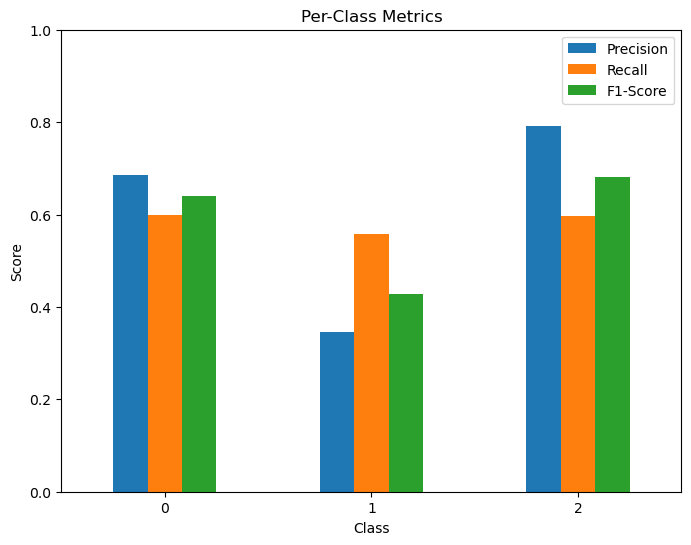

In [115]:
prec, rec, f1, _ = precision_recall_fscore_support(y_test_split, y_pred, average=None)

metrics_df = {
    "Class": ['0','1','2'],
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1
}

metrics_df = pd.DataFrame(metrics_df)

metrics_df.plot(x="Class", kind="bar", figsize=(8,6))
plt.title("Per-Class Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.show()